In [1]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial



## Imports for plotting

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

from einops import rearrange
from typing import Optional, Tuple

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100


# Import tensorboard
%load_ext tensorboard

from typing import Optional, List


<Figure size 640x480 with 0 Axes>

In [2]:

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "D:/Malky/research/data/mla_jax"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "D:/Malky/research/saved_models/mla_jax"



In [3]:

print("Device:", jax.devices()[0])

Device: TFRT_CPU_0


#### Step 1: Understand Multi-head Latent Attention (MLA)

MLA modifies the standard Multi-head Attention (MHA) by:

 1. **Compressing Keys and Values:** Instead of storing full KV matrices, MLA projects them into a low-dimensional latent space (e.g., from $d_{model}$ to $latent_dim$, where $latent_dim << d_{model}$) using a down-projection matrix.
 2. **Reconstructing Keys and Values:** During attention computation, latent vectors are up-projected back to the original dimension using separate matrices for keys and values.
 3. **Decoupled RoPE:** Positional information (via RoPE) is handled separately to maintain compatibility with KV compression.
 4. **Query Handling:** Queries can also be compressed into a latent space and then up-projected, though this is optional depending on the design.

 The goal is to reduce the KV cache size (e.g., from $O(num_heads * d_h)$ to $O(latent_dim)$ per token, where $num_heads$ is the **number of heads** and $d_h$ is **the head dimension**) while preserving attention quality.

 $X\in \mathbb{R}^{T x D }$, where $T$ represents the sequence length and $D$ is the hidden dimension. 

#### Step 2: Define the Architecture

- Down-projection: A linear layer to compress KV into a latent vector.
- Up-projection: Two linear layers to reconstruct keys and values from the latent vector.
- Query projection: Optionally compress queries into a latent space, though typically queries remain in full dimension for flexibility.
- RoPE: A custom implementation for positional embeddings, decoupled from KV compression.
- Attention computation: Standard scaled dot-product attention using the reconstructed keys and values.



In [4]:
def rotary_embedding(x, max_seq_len, dim):
    """Apply RoPE to input tensor x."""
    # Ensure max_seq_len is a concrete value, not symbolic
    positions = jnp.arange(max_seq_len, dtype=jnp.float32)
    
    # Ensure freqs is calculated with concrete values for dim
    freqs = 1.0 / (10000 ** (jnp.arange(0, dim, 2, dtype=jnp.float32) / dim))
    
    # Angle calculation with fixed values
    angles = positions[:, None] * freqs[None, :]
    
    sin, cos = jnp.sin(angles), jnp.cos(angles)
    
    # Apply rotary embeddings to the input tensor x
    x1, x2 = x[..., ::2], x[..., 1::2]
    x_rotated = jnp.concatenate([x1 * cos - x2 * sin, x1 * sin + x2 * cos], axis=-1)
    
    return x_rotated

In [5]:
# Scaled Dot-Product Attention

@jax.jit
def scaled_dot_product(q, k, v, mask=None):
    """Computes the scaled dot-product attention."""
    # q -> [B, n_h, L, d_h + d_h^R] 
    # k -> [B, n_h, L, d_h + d_h^R] 
    scale = jnp.sqrt(q.shape[-1])  # Scaling factor for attention scores  d_h + d_h_r
    scores = jnp.einsum("bhqd,bhkd->bhqk", q, k) / scale  # Efficient batch matmul
    
    if mask is not None:
        scores += mask  # Apply mask in-place

    attention = nn.softmax(scores, axis=-1)  # Compute attention weights
    values = jnp.einsum("bhqk,bhkd->bhqd", attention, v)  # Apply attention to values

    return values, attention

In [6]:
# Helper function to support different mask shapes.
# Output shape supports (B, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
@jax.jit
def expand_mask(mask):
    """Expands a mask tensor to shape (B, num_heads, L, L)."""
    ndim = mask.ndim
    assert ndim >= 2, "Mask must be at least 2D (L x L)"

    # Efficient broadcasting using jnp.reshape and jnp.expand_dims
    if ndim == 2:  # (L, L) → (1, 1, L, L)
        return mask[None, None, :, :]
    elif ndim == 3:  # (B, L, L) → (B, 1, L, L)
        return mask[:, None, :, :]
    
    return mask  # If already (B, num_heads, L, L), return as is

### Original MLA with ROPE 

In [7]:
class MultiHeadLatentAttentionRope(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension for KV
    d_c_: int  # Latent compression dimension for Queries
    d_h_R: int  # Rotated dimension for RoPE

    def setup(self):
        # self.d_h = self.d_model // self.n_h  # Head dimension
        self.input_h = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        # Combined projection for KV down-projection
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        # Combined projection for up-projecting KV
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Combined down-projection for Queries
        self.q_proj = nn.Dense(self.d_c_ + self.d_h_R * self.n_h, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        # Up-projection for Queries
        self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Rotated projection for keys (shared)
        self.kr_proj = nn.Dense(self.d_h_R , kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Output projection
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

    def __call__(self, x, mask=None):
        B, L, D = x.shape  # Batch size, Sequence length, Embedding dim

        if D != self.d_model:
            x = self.input_h(x)

        if mask is not None:
            mask = expand_mask(mask)

        # Down-project and up-project KV (fused ops)
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each


        # Down-project queries (fused with rotated part)
        c_q = self.q_proj(x)  # [B, L, d_c_ + d_h_R]
        q_c, q_r = jnp.split(c_q, [self.d_c_], axis=-1)  # [B, L, d_c_], [B, L, d_h_R]


        # Up-project compressed queries
        q_c = self.uq_proj(q_c)  # [B, L, d_model]

        # Apply RoPE (optimized via vmap)
        q_r = rotary_embedding(q_r, L, self.d_h_R * self.n_h)  # [batch_size, seq_len, d_h_R]
        k_r = rotary_embedding(self.kr_proj(x), L, self.d_h_R)  # [batch_size, seq_len, d_h_R]

        k_r = jnp.expand_dims(k_r, axis=2) # Shape: [batch_size, seq_len, 1, d_h_R]
        # Broadcast to the desired shape [batch_size, seq_len, num_heads, d_h_R]
       
        k_r = rearrange(jnp.broadcast_to(k_r, (k_r.shape[0], k_r.shape[1], self.n_h, k_r.shape[3])), "b l h d -> b h l d", h=self.n_h, l = L)
       
        # Reshape heads using einops (faster)
        q_c, k, v, q_r = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q_c, k, v, q_r])

    
        # Concatenate query and key rotated parts
        q = jnp.concatenate([q_c, q_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]
        k = jnp.concatenate([k, k_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]

        # Compute attention (efficient)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and project output
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention


### MLA

In [8]:
class MultiHeadLatentAttention(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension
    d_c_: int #Latent caompression dimension fro Q

    def setup(self):
        #self.d_h = self.d_model // self.n_h  # Head dimension

       # Fused projection layers for efficiency
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.q_proj = nn.Dense(self.d_c_, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

        # Up-projection for keys, values, and queries
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

        # Output projection
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros) 

    def __call__(self, x, mask=None):
        B, L, _ = x.shape  # Batch size, Sequence length, Embedding dim

        if mask is not None:
            mask = expand_mask(mask)

        # Compute compressed KV projection
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each

        # Compute query projection
        q = self.uq_proj(self.q_proj(x))  # [B, L, d_model]

        # Reshape using einops for efficiency
        q, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q, k, v])

        # Compute attention (optimized version)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and output projection
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention

In [9]:
# class MultiHeadLatentAttention(nn.Module):
#     d_model: int  # Output dimension
#     n_h: int  # Number of heads
#     d_c: int  # Latent compression dimension

#     def setup(self):
#         # self.d_h = self.d_model // self.n_h  # Head dimension
#         # self.d_h = self.d_model // self.n_h  # Head dimension
#         self.input_h = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
#         # Fused projection layers
#         self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
#         self.q_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
#         self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#         # Up-projection for keys & values
#         self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#     def __call__(self, x, mask=None):
#         B, L, D = x.shape  # Batch size, Sequence length, Embedding dim

#         if D != self.d_model:
#             x = self.input_h(x) 

#         if mask is not None:
#             mask = expand_mask(mask)

#         # Compute compressed KV projection
#         c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
#         k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each

#         # Compute query projection
#         q = self.q_proj(x)  # [B, L, d_model]

#         # Reshape using einops for efficiency
#         q, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q, k, v])

#         # Compute attention (optimized version)
#         values, attention = scaled_dot_product(q, k, v, mask)

#         # Reshape and output projection
#         values = rearrange(values, "b h l d -> b l (h d)")
#         return self.o_proj(values), attention

In [17]:
class TransformerBlock(nn.Module):
    """A Transformer block with RMS Norm and residual connections."""
    d_model: int  # Dimension of the model (hidden size)
    n_h: int  # Number of attention heads
    dim_feedforward: int    # Dimension of the feed-forward network
    dropout_rate: float = 0.1  # Dropout rate
    d_c : int = 64 # Latent dimension (d_c)
    d_c_: int = 64 # Latent dimension (d_c)
    d_h_R: int = 32  # Rotated dimension (d_h^R)
    position: bool = False


    def setup(self):
        # Attention layer
        if self.position:
            self.self_attn = MultiHeadLatentAttentionRope(
                d_model = self.d_model,
                n_h = self.n_h,
                d_c = self.d_c,
                d_c_ = self.d_c_,
                d_h_R = self.d_h_R)
        else:
            self.self_attn = MultiHeadLatentAttention(
                d_model = self.d_model,
                n_h = self.n_h,
                d_c = self.d_c,
                d_c_ = self.d_c_)
            

        # Feed-Forward Network
        self.ffn = [
            nn.Dense(features=self.dim_feedforward,
                     kernel_init=nn.initializers.xavier_uniform(),
                     bias_init=nn.initializers.zeros),
            nn.gelu,
            nn.Dropout(self.dropout_rate),
            nn.Dense(features=self.d_model,
                     kernel_init=nn.initializers.xavier_uniform(),
                     bias_init=nn.initializers.zeros),
            nn.Dropout(self.dropout_rate)
        ]
            
         
        # Layers to apply in between the main layers
        self.rmsNorm1 = nn.RMSNorm()
        self.rmsNorm2 = nn.RMSNorm()
        self.dropout = nn.Dropout(self.dropout_rate)


    
    def __call__(self, x: jnp.ndarray, mask: Optional[jnp.ndarray] = None, train: bool = False) -> jnp.ndarray:
        """
        Args:
            x: Input tensor of shape (batch, length, d_model)
            mask: Attention mask of shape (batch, heads, length, length) or None
            train: Whether in training mode (for dropout)
        Returns:
            Output tensor of shape (batch, length, d_model)
        """
        # First RMS Norm + Residual Connection
        residual = x
        x = self.rmsNorm1(x)
        x, _= self.self_attn(x, mask=mask)
        x = self.dropout(x, deterministic=not train)
        x = x + residual  # Residual connection

        # Second RMS Norm + Residual Connection
        residual = x
        x = self.rmsNorm2(x)
        x = self.dropout(x, deterministic=not train)


        for layer in self.ffn:
            x = layer(x) if not isinstance(layer, nn.Dropout) else layer(x, deterministic=not train)

        x = self.dropout(x, deterministic=not train)
        x = x + residual  # Residual connection

        return x

#### Test EncoderBlock implementation

In [18]:
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create encoder block
encblock = TransformerBlock(d_model=128, n_h=4, dim_feedforward=512, dropout_rate=0.1)
# Initialize parameters of encoder block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply({'params': params}, x, train=True,  rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del encblock, params

Out (3, 16, 128)


In [19]:
class TransformerEncoder(nn.Module):
    num_layers : int
    d_model: int  # Dimension of the model (hidden size)
    n_h: int  # Number of attention heads
    dim_feedforward: int    # Dimension of the feed-forward network
    dropout_rate: float = 0.1  # Dropout rate
    d_c : int = 64 # Latent dimension (d_c)
    d_c_: int = 64 # Latent dimension (d_c)
    d_h_R: int = 32  # Rotated dimension (d_h^R)
    position: bool = False

    def setup(self):

        # Initialize a list of Transformer blocks
        self.layers = [TransformerBlock(
            d_model=self.d_model,
            n_h=self.n_h,
            dim_feedforward=self.dim_feedforward,
            dropout_rate=self.dropout_rate,
            d_c=self.d_c,
            d_c_=self.d_c_,
            d_h_R=self.d_h_R,
            position=self.position
            ) for _ in range(self.num_layers)]


    def __call__(self, x:jnp.ndarray, mask:Optional[jnp.ndarray] = None, train:bool=True)-> jnp.ndarray:
        """
        Args:
            x: Input tensor of shape (batch, length, d_model)
            mask: Attention mask of shape (batch, heads, length, length) or None
            train: Whether in training mode (for dropout)
        Returns:
            Output tensor of shape (batch, length, d_model)
        """
        # Apply each Transformer block in sequence
        for layer in self.layers:
            x = layer(x, mask=mask, train=train)
        return x

    def get_attention_maps(self, x:jnp.ndarray, mask:Optional[jnp.ndarray] = None, train:bool=True)-> List[jnp.ndarray]:
        # A function to return the attention maps within the model for a single application
        # Used for visualization purpose later
        attention_maps = []
        for layer in self.layers:
    
            _, attn_map = layer.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = layer(x, mask=mask, train=train)
        return attention_maps

In [20]:
## Test TransformerEncoder implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 256))
# Create Transformer encoder
transenc = TransformerEncoder(num_layers=5,
                              d_model=256,
                              n_h=4,
                              dim_feedforward=256,
                              dropout_rate=0.15)

# Initialize parameters of transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']

# Apply transformer with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)


attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

Out (3, 16, 256)
Attention maps 5 (3, 4, 16, 16)


### Transformer Encoder predictor

In [21]:
class TransformerPredictor(nn.Module):
    
    num_classes : int                 # Number of classes to predict per sequence element
    num_layers : int
    d_model: int  # Dimension of the model (hidden size)
    n_h: int  # Number of attention heads
    dim_feedforward: int    # Dimension of the feed-forward network
    dropout_rate: float = 0.1  # Dropout rate
    input_dropout_prob : float = 0.0  # Dropout to apply on the input features
    d_c : int = 64 # Latent dimension (d_c)
    d_c_: int = 64 # Latent dimension (d_c)
    d_h_R: int = 32  # Rotated dimension (d_h^R)
    position: bool= False

    def setup(self):
        # Input dim -> Model dim
        self.input_dropout = nn.Dropout(self.input_dropout_prob)
        self.input_layer = nn.Dense(self.d_model)

        # Transformer encoder
        self.transformer = TransformerEncoder(
            num_layers=self.num_layers,
            d_model=self.d_model,
            n_h=self.n_h,
            dim_feedforward=self.dim_feedforward,
            dropout_rate=self.dropout_rate,
            d_c=self.d_c,
            d_c_=self.d_c_,
            d_h_R=self.d_h_R,
            position=self.position
        )

        # Output classifier per sequence element
        self.output_net = [
            nn.Dense(self.d_model),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(self.dropout_rate),
            nn.Dense(self.num_classes)
        ]


    def __call__(self, x:jnp.ndarray, mask:Optional[jnp.ndarray] = None, train:bool=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
            train - If True, dropout is stochastic
        """

        # Apply input dropout and linear transformation
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)

        # Apply Transformer encoder
        x = self.transformer(x, mask=mask, train=train)


 
        for layer in self.output_net:
            x = layer(x) if not isinstance(layer, nn.Dropout) else layer(x, deterministic=not train)
        return x
        

    def get_attention_maps(self, x:jnp.ndarray, mask:Optional[jnp.ndarray] = None, train:bool=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        # Apply input dropout and linear transformation
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)

        # Get attention maps from the Transformer encoder
        attention_maps = self.transformer.get_attention_maps(x, mask=mask, train=train)
        return attention_maps

In [22]:
## Test TransformerPredictor implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 64))
# Create Transformer encoder


transpre = TransformerPredictor(num_layers=5,
                                d_model=128,
                                num_classes=10,
                                n_h=4,
                                dim_feedforward = 128,
                                dropout_rate=0.15,
                                input_dropout_prob=0.05, position=True)
# Initialize parameters of transformer predictor with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transpre, binded_mod, params

Out (3, 16, 10)
Attention maps 5 (3, 4, 16, 16)


In [23]:
class TrainerModule:

    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=42, **model_kwargs):
        """
        Inputs:
            model_name - Name of the model. Used for saving and checkpointing
            exmp_batch - Example batch to the model for initialization
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            seed - Seed to use for model init
        """
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr
        self.warmup = warmup
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = TransformerPredictor(**model_kwargs)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_batch)

    def batch_to_input(self, exmp_batch):
        # Map batch to input data to the model
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def get_loss_function(self):
        # Return a function that calculates the loss for a batch
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def create_functions(self):
        # Create jitted train and eval functions
        calculate_loss = self.get_loss_function()

        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)  
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)

        # Evaluation function
        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_batch):
        # Initialize model
        self.rng = jax.random.PRNGKey(self.seed)
        self.rng, init_rng, dropout_init_rng = jax.random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.schedules.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=1e-9
        )

        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            # optax.adam(lr_schedule)
            optax.adamw(lr_schedule)
            # optax.adamw(lr_schedule, b1=0.9, b2 = 0.95, weight_decay=0.12)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=500):
        # Train model for defined number of epochs
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 5 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        accs, losses = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        self.logger.add_scalar('train/accuracy', avg_acc, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all data points of a data loader and return avg accuracy
        correct_class, count = 0, 0
        for batch in data_loader:
            acc, self.rng = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, step=step)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for the pretrained model
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this Transformer
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [18]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size, np_rng):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.np_rng = np_rng

        self.data = self.np_rng.integers(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.flip(inp_data, axis=0)
        return inp_data, labels

In [32]:
# Combine batch elements (all numpy) by stacking
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = partial(ReverseDataset, 10, 16)
rev_train_loader = data.DataLoader(dataset(50000, np_rng=np.random.default_rng(42)),
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(43)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(dataset(10000, np_rng=np.random.default_rng(44)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)

NameError: name 'ReverseDataset' is not defined

In [20]:
inp_data, labels = rev_train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: [0 7 6 4 4 8 0 6 2 0 5 9 7 7 7 7]
Labels:     [7 7 7 7 9 5 0 2 6 0 8 4 4 6 7 0]


In [21]:
class ReverseTrainer(TrainerModule):

    def batch_to_input(self, batch):
        inp_data, _ = batch

        inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
        return inp_data

    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, labels = batch
            inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, train=train, rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        return calculate_loss

In [23]:
def train_reverse(max_epochs=20, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = ReverseTrainer(model_name='ReverseTask',
                             exmp_batch=next(iter(rev_train_loader)),
                             max_iters=num_train_iters,
                             **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(rev_train_loader, rev_val_loader, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [24]:
d_model=16
n_h = 1
d_h = d_model//n_h #(full per-head dimension),
d_c = d_h - 4 #(key-value compression dimension)
d_c_ =  d_h - 6   # (query compression dimension)
dhR = 12  #decoupled RoPE dimension


reverse_trainer, reverse_result = train_reverse(d_model=d_model,
                                                n_h=n_h,
                                                num_classes=rev_train_loader.dataset.num_categories,
                                                num_layers=1,
                                                dim_feedforward = d_model * 4,
                                                dropout_rate=0.1,
                                                d_c = d_c, 
                                                d_c_= d_c_,
                                                d_h_R= dhR,
                                                position= True,
                                                lr=2e-3,
                                                warmup=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

In [25]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  30.97%
Test accuracy: 30.72%


In [26]:
iter(rev_train_loader)

In [27]:
data_input, labels = next(iter(rev_val_loader))
inp_data = jax.nn.one_hot(data_input, num_classes=reverse_trainer.model.num_classes)
attention_maps = reverse_trainer.model_bd.get_attention_maps(x = inp_data, train= False)

In [28]:
attention_maps[0].shape

(128, 1, 16, 16)

In [46]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = jax.device_get(input_data[idx])
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [jax.device_get(m[idx]) for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

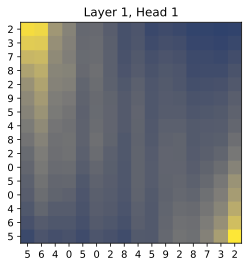

In [30]:
plot_attention_maps(data_input, attention_maps, idx=0)

In [32]:
# %tensorboard --logdir D:/Malky/research/saved_models/mla_jax/ReverseTask

#### Set Anomaly Detection

In [24]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = img / 255.   # Normalization is done in the ResNet
    return img

# Resize to 224x224, and map to JAX
transform = transforms.Compose([transforms.Resize((224,224)),
                                image_to_numpy
                               ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

# For later, keep a dictionary mapping class indices to class names
class_idx_to_name = {val: key for key, val in train_set.class_to_idx.items()}

In [25]:
# Import and install flaxmodels if needed
try:
    import flaxmodels
except ModuleNotFoundError:
    !pip install --upgrade flaxmodels
    # !pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git
    import flaxmodels

# Pretrained ResNet34 on ImageNet
resnet34 = flaxmodels.ResNet34(output='activations', pretrained='imagenet', normalize=True)
main_rng, resnet_rng = random.split(main_rng, 2)
resnet_params = resnet34.init(resnet_rng, jnp.zeros((1, 224, 224, 3)))
# Jit its forward pass for efficiency
apply_resnet = jax.jit(lambda imgs: resnet34.apply(resnet_params, imgs, train=False))

In [26]:
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False,
                                      collate_fn=lambda batch: np.stack([b[0] for b in batch], axis=0))
        extracted_features = []
        for imgs in tqdm(data_loader):
            feats = apply_resnet(imgs)
            # Average pooling on the last conv features to obtain a image-level feature vector
            feats = feats['block4_2'].mean(axis=(1,2))
            extracted_features.append(feats)
        extracted_features = jnp.concatenate(extracted_features, axis=0)
        extracted_features = jax.device_get(extracted_features)
        np.savez_compressed(save_file, feats=extracted_features)
    else:
        extracted_features = np.load(save_file)['feats']
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.npz")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.npz")
test_feats = extract_features(test_set, test_feat_file)

In [27]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: (50000, 512)
Test:  (10000, 512)


In [28]:
## Split train into train+val
# Get labels from train set
labels = np.array(train_set.targets, dtype=np.int32)

# Get indices of images per class
num_labels = labels.max()+1
sorted_indices = np.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [29]:
class SetAnomalyDataset(data.Dataset):

    def __init__(self, img_feats, labels, np_rng, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.np_rng = np_rng
        self.set_size = set_size-1  # The set size is here the number of images from the same class per set
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = np.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()

    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = np.stack(test_sets, axis=0)
        return test_sets

    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = self.np_rng.integers(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = self.np_rng.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices

    def __len__(self):
        return self.img_feats.shape[0]

    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = np.concatenate([self.img_feats[img_indices], anomaly[None]], axis=0)
        indices = np.concatenate([img_indices, np.array([idx], dtype=np.int32)], axis=0)
        label = img_set.shape[0]-1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

In [33]:
# Combine batch elements (all numpy) by stacking
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


In [34]:
SET_SIZE = 10
test_labels = np.array(test_set.targets, dtype=np.int32)

anom_train_dataset = SetAnomalyDataset(train_feats, train_labels, np_rng=np.random.default_rng(42), set_size=SET_SIZE, train=True)
anom_val_dataset   = SetAnomalyDataset(val_feats,   val_labels,   np_rng=np.random.default_rng(43), set_size=SET_SIZE, train=False)
anom_test_dataset  = SetAnomalyDataset(test_feats,  test_labels,  np_rng=np.random.default_rng(123), set_size=SET_SIZE, train=False)

anom_train_loader = data.DataLoader(anom_train_dataset, batch_size=64, shuffle=True,  drop_last=True,  collate_fn=numpy_collate)
anom_val_loader   = data.DataLoader(anom_val_dataset,   batch_size=64, shuffle=False, drop_last=False, collate_fn=numpy_collate)
anom_test_loader  = data.DataLoader(anom_test_dataset,  batch_size=64, shuffle=False, drop_last=False, collate_fn=numpy_collate)

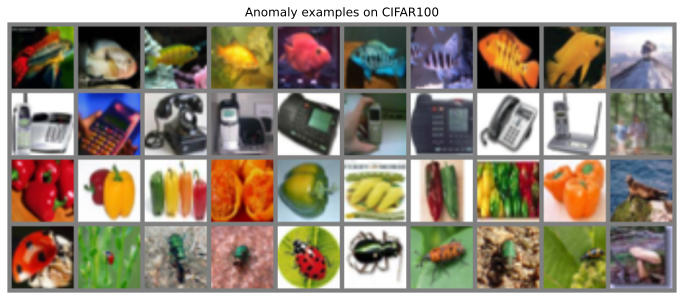

In [35]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = jax.device_get(jnp.stack(images, axis=0)).astype(np.float32)
    images = torch.from_numpy(images)
    images = images.permute(0, 3, 1, 2)
    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(anom_test_loader))
visualize_exmp(indices[:4], test_set)

In [36]:
class AnomalyTrainer(TrainerModule):

    def batch_to_input(self, batch):
        inp_data, _, _ = batch
        return inp_data

    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, _, labels = batch
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data,
                                      train=train,
                                      rngs={'dropout': dropout_apply_rng})
            logits = logits.squeeze(axis=-1)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).astype(jnp.float32).mean()
            return loss, (acc, rng)
        return calculate_loss

In [51]:
def train_anomaly(max_epochs=50, **model_args):
    num_train_iters = len(anom_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = AnomalyTrainer(model_name='SetAnomalyTaskLatentQ_lower',
                             exmp_batch=next(iter(anom_train_loader)),
                             max_iters=num_train_iters,
                             **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(anom_train_loader, anom_val_loader, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    train_acc = trainer.eval_model(anom_train_loader)
    val_acc = trainer.eval_model(anom_val_loader)
    test_acc = trainer.eval_model(anom_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc}

In [52]:
d_model = 128
n_h = 4
d_h = d_model//n_h
d_c = d_h // 2
d_c_ = d_h // 4

anomaly_trainer, anomaly_result = train_anomaly(d_model=d_model,
                                                n_h=n_h,
                                                num_classes=1,
                                                num_layers=4,
                                                dim_feedforward = 512,
                                                dropout_rate=0.1,
                                                input_dropout_prob=0.1,
                                                d_c = d_c,
                                                d_c_= d_c_,
                                                position= False,
                                                lr=5e-4,
                                                warmup=100)

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

In [54]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 97.62%
Val accuracy:   94.80%
Test accuracy:  94.50%


In [55]:
inp_data, indices, labels = next(iter(anom_test_loader))
preds = anomaly_trainer.model_bd(inp_data, train=False)
preds = jax.nn.softmax(preds.squeeze(axis=-1))

permut = np.random.permutation(inp_data.shape[1])
permut_inp_data = inp_data[:,permut]
perm_preds = anomaly_trainer.model_bd(permut_inp_data, train=False)
perm_preds = jax.nn.softmax(perm_preds.squeeze(axis=-1))

preds = jax.device_get(preds)
perm_preds = jax.device_get(perm_preds)

assert np.abs(preds[:,permut] - perm_preds).max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut])
print("Permuted preds\n", perm_preds[0])

Preds
 [9.46604146e-08 9.99997973e-01 1.07263440e-06 1.97121494e-07
 7.76775906e-08 1.07182494e-07 6.10040374e-08 5.07627682e-08
 6.93985100e-08 2.92401637e-07]
Permuted preds
 [9.4660216e-08 9.9999785e-01 1.0726312e-06 1.9712108e-07 7.7677583e-08
 1.0718228e-07 6.1003917e-08 5.0762761e-08 6.9398503e-08 2.9240104e-07]


In [56]:
attention_maps = anomaly_trainer.model_bd.get_attention_maps(inp_data, train=False)
predictions = preds.argmax(axis=-1)

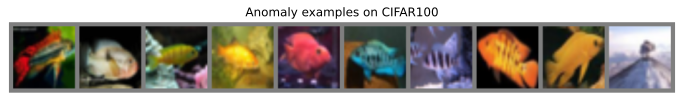

Main class: aquarium_fish, Anomaly class: mountain
Prediction: image 9


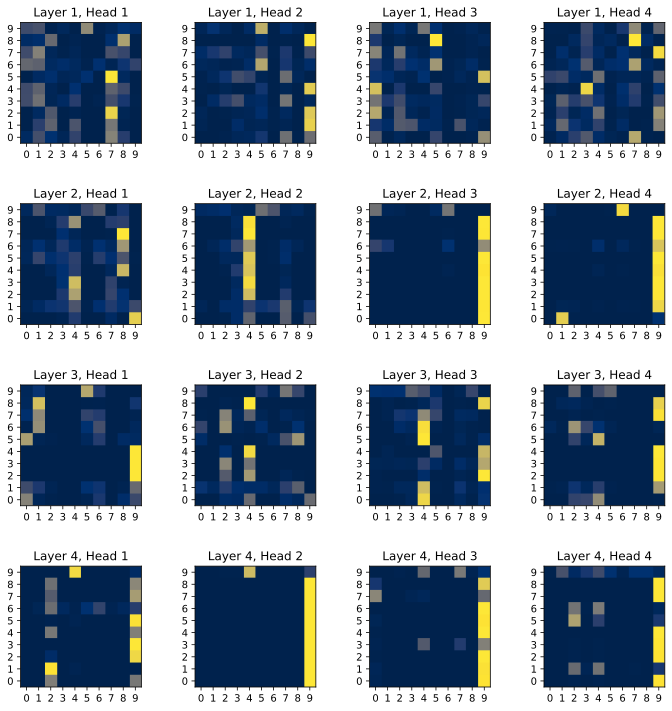

In [57]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print(f'Main class: {class_idx_to_name[test_labels[indices[idx,0]]]}, Anomaly class: {class_idx_to_name[test_labels[indices[idx,-1]]]}')
    print(f'Prediction: image {predictions[idx].item()}')
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

In [62]:
mistakes = np.where(predictions != 9)[0]
print("Indices with mistake:", mistakes)

Indices with mistake: [10]


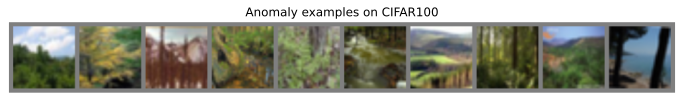

Main class: forest, Anomaly class: sea
Prediction: image 2


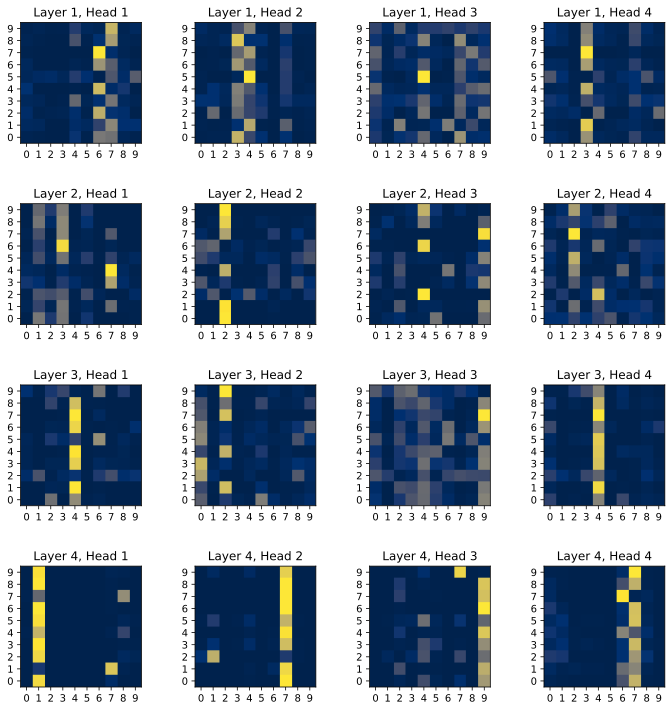

Probabilities:
Image 0: 1.83%
Image 1: 1.30%
Image 2: 81.87%
Image 3: 0.56%
Image 4: 0.37%
Image 5: 1.24%
Image 6: 7.05%
Image 7: 0.24%
Image 8: 2.20%
Image 9: 3.33%


In [63]:
visualize_prediction(mistakes[0])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[0]]):
    print(f"Image {i}: {100.0*p:4.2f}%")